# Aim

To understand the sparse decoding algorithm from scratch, this is a full implementation of the algorithm just off the paper (Ramchandran-papers.nips.cc-2015).

A lot of things should be vectorizable, but the dimensions aren't happy with that so I'll just ignore it. So there may be slight inefficiencies here.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import itertools
%matplotlib inline

In [2]:
def myfwht(x):
    """Recursive implementation of the 1D Cooley-Tukey FFT"""
    # x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N == 1:
        return x
    else:
        X_even = myfwht(x[0:(N//2)])
        X_odd = myfwht(x[(N//2):])
        return np.concatenate([(X_even + X_odd),
                               (X_even - X_odd)])
    
def bin_to_dec(x):
    n = len(x)
    c = 2**(np.arange(n)[::-1])
    return c.dot(x).astype(np.int)

In [3]:
def make_input_signal(n, loc, strengths, noise_sd):
    '''
    Arguments
    ---------
    n : int
    number of bits
    
    loc : iterable
    Locations of peaks in the W-H spectrum. Elements must be integers in [0, 2 ** n - 1].
    
    strengths : iterable
    The strength of each peak in the W-H spectrum. Defaults to all 1s. Dimension has to match that of loc.
    
    noise_sd : scalar
    The SD of the added noise.
    
    Returns
    -------
    input_signal : numpy.ndarray
    The time signal.
    
    input_wht : numpy.ndarray
    The WHT of input_signal.
    '''
    N = 2 ** n
    if strengths is None:
        strengths = np.ones_like(loc)
    input_wht = np.zeros((N,))
    for l, s in zip(loc, strengths):
        input_wht[l] = s
    input_signal = myfwht(input_wht) + np.random.normal(0, noise_sd, (N,))
    return input_signal, myfwht(input_signal) / N

class InputSignal:
    def __init__(self, n, loc, strengths=None, noise_sd=0):
        self.n = n
        self.noise_sd = noise_sd
        self.signal_t, self.signal_w = make_input_signal(n, loc, strengths, noise_sd)


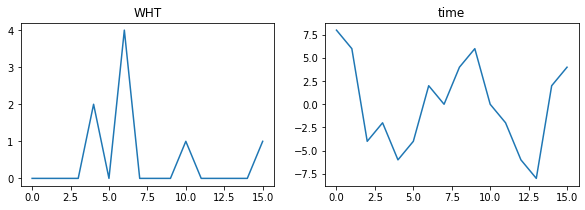

In [4]:
# verify that this works just like Orhan's
# make signal and plot it
input_signal = InputSignal(4, [4, 6, 10, 15], strengths=[2, 4, 1, 1], noise_sd=0)
fig, axs = plt.subplots(1,2, figsize=(10,3))

axs[0].plot(input_signal.signal_w)
axs[0].set_title('WHT')

axs[1].plot(input_signal.signal_t)
axs[1].set_title('time')
plt.show()

In [5]:
def subsample_indices(b, M, d):
    '''
    Query generator: creates indices for signal subsamples.
    
    Arguments
    ---------
    b : int
    The subsampling coefficient; subject to b <= n = log2(N).
    
    M : numpy.ndarray, shape (n, b)
    The subsampling matrix; takes on binary values.
    
    d : numpy.ndarray, shape (n,)
    The subsampling offset; takes on binary values.
    
    Returns
    -------
    indices : numpy.ndarray, shape (B,)
    The (decimal) subsample indices. Mostly for debugging purposes.
    
    subsamples : numpy.ndarray, shape (B,)
    The subsampled time signal.
    '''
    B = 2 ** b
    L = np.array(list(map(list, itertools.product([0, 1], repeat=b)))).T
    indices = bin_to_dec(np.mod(np.dot(M, L).T + d, 2).T)
    return indices

In [6]:
# implementing the example in the paper section 2.2

M1 = np.vstack((np.zeros((2,2)), np.eye(2)))
M2 = np.vstack((np.eye(2), np.zeros((2,2))))

In [7]:
# check linear combinations of subsampling
M1_subsampled_wht = myfwht(input_signal.signal_t[subsample_indices(2, M1, np.zeros(4,))]) / 4
assert np.allclose(M1_subsampled_wht, np.array([np.sum([input_signal.signal_w[i::4]]) for i in range(4)]))

In [8]:
def singleton_detection_noiseless(U_slice):
    '''
    Finds the true index of a singleton, assuming that it is one.
    Works on a fixed M, and assumes P = n + 1 and D = [0; I]
    
    Arguments
    ---------
    U_slice : numpy.ndarray, (P,).
    The WHT component of the subsampled bin we care about, at diff delays.
    d[0] is the zero array, I think (is this necessary? probably)
    
    Returns
    -------
    k : numpy.ndarray
    Index of the corresponding right node.
    '''
    return (-np.sign(U_slice * U_slice[0])[1:]/2 + 1/2).astype(np.int)

def singleton_detection(U_slice, D):
    '''
    As in singleton_detection_noiseless, but with noise.
    '''
    pass
    

In [9]:
D = np.vstack((np.zeros(4,), np.eye(4)))
all_delay_subsamples = np.array([input_signal.signal_t[subsample_indices(2, M1, D[i])] for i in range(5)])
all_delay_fwht = np.array([myfwht(row) for row in all_delay_subsamples])

In [10]:
all_delay_fwht

array([[  8.,   0.,  20.,   4.],
       [  8.,   0.,  12.,  -4.],
       [ -8.,   0., -12.,  -4.],
       [  8.,   0., -20.,  -4.],
       [  8.,   0.,  20.,  -4.]])

In [11]:
singleton_detection_noiseless(all_delay_fwht[:,0]) # should be 0, 1, 0, 0

array([0, 1, 0, 0])

In [12]:
def singleton_detection(U_slice):
    '''
    Noisy singleton detection, as in [2], section 5.2.
    '''
    return singleton_detection_noiseless(U_slice)

def compute_delayed_wht(signal, b, M, num_delays):
    '''
    Helper function for bin_cardinality. Creates random delays, subsamples according to M and the random delays,
    and returns the subsample WHT along with the delays.
    '''
    if signal.noise_sd > 0:
        D = np.random.binomial(1, 0.5, (num_delays, signal.n)) # create random delays matrix
    else:
        D = np.vstack((np.zeros(signal.n,), np.eye(signal.n)))
    samples_to_transform = signal.signal_t[np.array([subsample_indices(b, M, d) for d in D])] # subsample to allow small WHTs
    U = np.array([myfwht(row) for row in samples_to_transform]) # compute the small WHTs
    return U, D

def bin_cardinality(signal, M, num_delays=None):
    '''
    Computes delayed WHT observations and declares cardinality based on that.
    2 is a stand-in for any cardinality > 1. (Bad design, but I can't think
    of a better way)
    
    Arguments
    ---------
    signal : InputSignal
    The input signal object.

    b : int
    M : numpy.ndarray
    
    As in the signature to subsample_indices.
    
    num_delays : int
    The number of delays to apply; or, the number of rows in the delays matrix.

    Returns
    -------
    cardinality : numpy.ndarray
    0 or 1 if the bin is a zeroton or singleton resp.; 2 if multiton.
    
    singleton_indices : list
    A list (in decimal form for compactness) of the k values of the singletons. 
    Length matches the number of 1s in cardinality.
    '''
    b = M.shape[1]
    if num_delays is None:
        num_delays = signal.n + 1
    U, D = compute_delayed_wht(signal, b, M, num_delays)
    cardinality = np.ones((signal.n,), dtype=np.int) # vector of indicators
    singleton_indices = []
    cutoff = signal.noise_sd ** 2 / (2 ** b) # threshold from [1] section 3.2, but this seems too low?
    
    # it's 0.01 / 4, and all noise will be bigger than that so I think the threshold should be different.
    # because this is too low, a column that's actually noisy is getting flagged as signal
    # Therefore nothing ever gets flagged as a zeroton
    # and after subtracting off the best singleton approximation, it's still too big to be noise
    for i, col in enumerate(U.T):
        print("Column:   ", col)
        # <col, col> = |col|^2 = |U|^2
        if np.inner(col, col) / num_delays <=  2 * cutoff:
            cardinality[i] = 0
        else:
            k = singleton_detection(col)
            residual = col - col[0] * (-1) ** np.dot(D, k)
            print("Residual: ", residual)
            if np.inner(residual, residual) > cutoff:
                cardinality[i] = 2
            else:
                singleton_indices.append(bin_to_dec(k))
                print("Slice {0} has k = {1}".format(i, k))
    return cardinality, singleton_indices

In [13]:
bin_cardinality(input_signal, M1) # should be 1, 0, 2, 1

Column:    [ 8.  8. -8.  8.  8.]
Residual:  [0. 0. 0. 0. 0.]
Slice 0 has k = [0 1 0 0]
Column:    [0. 0. 0. 0. 0.]
Column:    [ 20.  12. -12. -20.  20.]
Residual:  [ 0. -8.  8.  0.  0.]
Column:    [ 4. -4. -4. -4. -4.]
Residual:  [0. 0. 0. 0. 0.]
Slice 3 has k = [1 1 1 1]


(array([1, 0, 2, 1]), [4, 15])

In [14]:
bin_cardinality(input_signal, M2) # should be 0, 2, 1, 1

Column:    [0. 0. 0. 0. 0.]
Column:    [ 24.  24. -24.  -8.  24.]
Residual:  [ 0.  0.  0. 16.  0.]
Column:    [ 4. -4.  4. -4.  4.]
Residual:  [0. 0. 0. 0. 0.]
Slice 2 has k = [1 0 1 0]
Column:    [ 4. -4. -4. -4. -4.]
Residual:  [0. 0. 0. 0. 0.]
Slice 3 has k = [1 1 1 1]


(array([0, 2, 1, 1]), [10, 15])

In [15]:
def decode(signal, Ms, nums_delays=None):
    '''
    Full SPRIGHT decoding. Implements 
    '''
    true_wht = np.zeros_like(signal.signal_t)
    c = len(Ms)
    b = Ms[0].shape[1]
    Us, Ds = [], []
    singletons = {}
    multitons = []
    if nums_delays is None:
        nums_delays = [signal.n + 1] * c
    for M, num_delays in zip(Ms, nums_delays):
        U, D = compute_delayed_wht(signal, b, M, num_delays)
        Us.append(U)
        Ds.append(D)
    
    cutoff = signal.noise_sd ** 2 / (2 ** b) # threshold from [1] section 3.2, but this seems too low?
    while True:
        singletons = {}
        multitons = []
        for i, (U, D) in enumerate(zip(Us, Ds)):
            for j, col in enumerate(U.T):
                if np.inner(col, col) / num_delays >  2 * cutoff:
                    k = singleton_detection(col)
                    residual = col - col[0] * (-1) ** np.dot(D, k)
                    if np.inner(residual, residual) > cutoff:
                        multitons.append((i, j))
                    else:
                        singletons[(i, j)] = k

        print("Singletons: {0}\n".format(singletons))
        print("Multitons : {0}\n".format(multitons))
        if len(multitons) == 0:
            break
        for (i, j) in singletons:
            k = singletons[(i, j)]
            potential_peels = [(l, bin_to_dec(M.T.dot(k))) for l, M in enumerate(Ms)]
            for peel in potential_peels:
                if peel in multitons:
                    Us[peel[0]][:,peel[1]] -= Us[i][:,j]
                    print("Peeled {0} at position {1} off multiton {2}".format(bin_to_dec(k), (i, j), peel))
                    
    for position in singletons:
        idx = bin_to_dec(singletons[position])
        val = Us[position[0]][0, position[1]]
        if true_wht[idx] == 0:
            true_wht[idx] = val
        else:
            true_wht[idx] = (true_wht[idx] + val) / 2 # average out noise
    
    true_wht /= 2 ** (signal.n / b)
    return true_wht

Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 3): array([1, 1, 1, 1]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : [(0, 2), (1, 1)]

Peeled 4 at position (0, 0) off multiton (1, 1)
Peeled 10 at position (1, 2) off multiton (0, 2)
Singletons: {(0, 0): array([0, 1, 0, 0]), (0, 2): array([0, 1, 1, 0]), (0, 3): array([1, 1, 1, 1]), (1, 1): array([0, 1, 1, 0]), (1, 2): array([1, 0, 1, 0]), (1, 3): array([1, 1, 1, 1])}

Multitons : []



<StemContainer object of 3 artists>

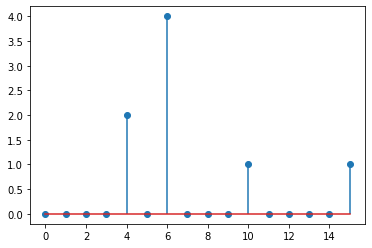

In [16]:
decoded = decode(input_signal, [M1, M2])
plt.stem(decoded, use_line_collection=True)

In [17]:
assert np.allclose(decoded, input_signal.signal_w)

1. Naive noisy (Maximum likelihood). Requires taking random delays and going through all the possible locations mapping to a bin, creating signatures, and decoding by MLE (take an argmax). This is good in sample complexity, but bad in time complexity.
2. SO-SPRIGHT with BCH, or with different types of codes (up to me). Need a good binary symmetric channel code (n, k, d).

Codes come with three parameters: 
- n: length of codeword, in this setting = number of delays
- k: length of thing to be recovered. Say signal length is 2^m then k = m.
- d: minimum distance. Can tolerate (d + 1) / 2 errors.

In our problem m is given; can make it larger but not smaller. Say the SNR is changing. Need to look for codes where n increases but k stays the same.

BCH may have specific lengths, adjust the signal length to fit that. Don't zero-pad for now.
BCH should work for small noise.

**References**

[1] Li, X., Ramchandran, K. (2015). An Active Learning Framework using Sparse-Graph Codes for Sparse Polynomials and Graph Sketching. NeurIPS, http://papers.neurips.cc/paper/5697-an-active-learning-framework-using-sparse-graph-codes-for-sparse-polynomials-and-graph-sketching.pdf
[2] Li, X., Bradley, J., Pawar, S., Ramchandran, K. (2015). SPRIGHT: A Fast and Robust Framework for Sparse Walsh-Hadamard Transform. arXiv.org. cs.IT()https://arxiv.org/abs/1508.06336